In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


1/7 [===>..........................] - ETA: 14s - loss: 0.3172 - STD: 1.6952e-04 - MAE: 0.5543

2/7 [=======>......................] - ETA: 0s - loss: 0.2221 - STD: 4.3681e-04 - MAE: 0.4484 

3/7 [===========>..................] - ETA: 0s - loss: 0.1579 - STD: 5.4505e-04 - MAE: 0.3505

4/7 [================>.............] - ETA: 0s - loss: 0.1210 - STD: 5.2275e-04 - MAE: 0.2830

5/7 [====================>.........] - ETA: 0s - loss: 0.1131 - STD: 4.6543e-04 - MAE: 0.2428

6/7 [========================>.....] - ETA: 0s - loss: 0.0952 - STD: 4.0868e-04 - MAE: 0.2189

7/7 [==============================] - ETA: 0s - loss: 0.0836 - STD: 3.6028e-04 - MAE: 0.2041

7/7 [==============================] - 6s 509ms/step - loss: 0.0836 - STD: 3.6028e-04 - MAE: 0.2041 - val_loss: 0.0241 - val_STD: 3.5807e-05 - val_MAE: 0.1239


Epoch 2/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0251 - STD: 4.1050e-05 - MAE: 0.1259

2/7 [=======>......................] - ETA: 2s - loss: 0.0262 - STD: 3.2812e-05 - MAE: 0.1295

3/7 [===========>..................] - ETA: 2s - loss: 0.0270 - STD: 2.6798e-05 - MAE: 0.1323

4/7 [================>.............] - ETA: 1s - loss: 0.0277 - STD: 2.2425e-05 - MAE: 0.1345

5/7 [====================>.........] - ETA: 1s - loss: 0.0282 - STD: 1.8880e-05 - MAE: 0.1363

6/7 [========================>.....] - ETA: 0s - loss: 0.0286 - STD: 1.6215e-05 - MAE: 0.1377

7/7 [==============================] - ETA: 0s - loss: 0.0287 - STD: 1.4296e-05 - MAE: 0.1386

7/7 [==============================] - 4s 542ms/step - loss: 0.0287 - STD: 1.4296e-05 - MAE: 0.1386 - val_loss: 0.0292 - val_STD: 3.7626e-06 - val_MAE: 0.1414


Epoch 3/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0306 - STD: 4.7195e-06 - MAE: 0.1443

2/7 [=======>......................] - ETA: 2s - loss: 0.0303 - STD: 5.2085e-06 - MAE: 0.1435

3/7 [===========>..................] - ETA: 2s - loss: 0.0302 - STD: 5.8179e-06 - MAE: 0.1429

4/7 [================>.............] - ETA: 1s - loss: 0.0299 - STD: 6.3866e-06 - MAE: 0.1422

5/7 [====================>.........] - ETA: 1s - loss: 0.0296 - STD: 7.0349e-06 - MAE: 0.1412

6/7 [========================>.....] - ETA: 0s - loss: 0.0293 - STD: 7.6454e-06 - MAE: 0.1402

7/7 [==============================] - ETA: 0s - loss: 0.0292 - STD: 8.0993e-06 - MAE: 0.1389

7/7 [==============================] - 4s 536ms/step - loss: 0.0292 - STD: 8.0993e-06 - MAE: 0.1389 - val_loss: 0.0245 - val_STD: 1.0081e-05 - val_MAE: 0.1252


Epoch 4/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0258 - STD: 1.2185e-05 - MAE: 0.1279

2/7 [=======>......................] - ETA: 2s - loss: 0.0250 - STD: 1.2915e-05 - MAE: 0.1253

3/7 [===========>..................] - ETA: 2s - loss: 0.0244 - STD: 1.2781e-05 - MAE: 0.1229

4/7 [================>.............] - ETA: 1s - loss: 0.0236 - STD: 1.3066e-05 - MAE: 0.1202

5/7 [====================>.........] - ETA: 1s - loss: 0.0229 - STD: 1.3382e-05 - MAE: 0.1175

6/7 [========================>.....] - ETA: 0s - loss: 0.0226 - STD: 1.3885e-05 - MAE: 0.1144

7/7 [==============================] - ETA: 0s - loss: 0.0216 - STD: 1.4265e-05 - MAE: 0.1114

7/7 [==============================] - 4s 548ms/step - loss: 0.0216 - STD: 1.4265e-05 - MAE: 0.1114 - val_loss: 0.0139 - val_STD: 1.2301e-05 - val_MAE: 0.0853


Epoch 5/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0146 - STD: 1.5023e-05 - MAE: 0.0869

2/7 [=======>......................] - ETA: 2s - loss: 0.0139 - STD: 1.5972e-05 - MAE: 0.0845

3/7 [===========>..................] - ETA: 2s - loss: 0.0132 - STD: 1.6044e-05 - MAE: 0.0824

4/7 [================>.............] - ETA: 1s - loss: 0.0129 - STD: 1.6172e-05 - MAE: 0.0809

5/7 [====================>.........] - ETA: 0s - loss: 0.0123 - STD: 1.6264e-05 - MAE: 0.0800

6/7 [========================>.....] - ETA: 0s - loss: 0.0118 - STD: 1.6018e-05 - MAE: 0.0796

7/7 [==============================] - ETA: 0s - loss: 0.0116 - STD: 1.5607e-05 - MAE: 0.0799

7/7 [==============================] - 4s 553ms/step - loss: 0.0116 - STD: 1.5607e-05 - MAE: 0.0799 - val_loss: 0.0102 - val_STD: 1.4638e-05 - val_MAE: 0.0836


Epoch 6/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0106 - STD: 1.6199e-05 - MAE: 0.0850

2/7 [=======>......................] - ETA: 2s - loss: 0.0109 - STD: 1.4389e-05 - MAE: 0.0868

3/7 [===========>..................] - ETA: 2s - loss: 0.0112 - STD: 1.3629e-05 - MAE: 0.0885

4/7 [================>.............] - ETA: 1s - loss: 0.0113 - STD: 1.3330e-05 - MAE: 0.0898

5/7 [====================>.........] - ETA: 0s - loss: 0.0115 - STD: 1.2708e-05 - MAE: 0.0908

6/7 [========================>.....] - ETA: 0s - loss: 0.0116 - STD: 1.2163e-05 - MAE: 0.0912

7/7 [==============================] - ETA: 0s - loss: 0.0117 - STD: 1.1998e-05 - MAE: 0.0912

7/7 [==============================] - 4s 548ms/step - loss: 0.0117 - STD: 1.1998e-05 - MAE: 0.0912 - val_loss: 0.0109 - val_STD: 9.7837e-06 - val_MAE: 0.0876


Epoch 7/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0112 - STD: 1.0889e-05 - MAE: 0.0889

2/7 [=======>......................] - ETA: 2s - loss: 0.0110 - STD: 1.0260e-05 - MAE: 0.0873

3/7 [===========>..................] - ETA: 2s - loss: 0.0108 - STD: 1.0209e-05 - MAE: 0.0858

4/7 [================>.............] - ETA: 1s - loss: 0.0106 - STD: 9.7826e-06 - MAE: 0.0845

5/7 [====================>.........] - ETA: 0s - loss: 0.0105 - STD: 8.8430e-06 - MAE: 0.0833

6/7 [========================>.....] - ETA: 0s - loss: 0.0104 - STD: 8.5187e-06 - MAE: 0.0822

7/7 [==============================] - ETA: 0s - loss: 0.0103 - STD: 8.3847e-06 - MAE: 0.0815

7/7 [==============================] - 4s 552ms/step - loss: 0.0103 - STD: 8.3847e-06 - MAE: 0.0815 - val_loss: 0.0095 - val_STD: 5.1205e-06 - val_MAE: 0.0744


Epoch 8/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0100 - STD: 7.3668e-06 - MAE: 0.0760

2/7 [=======>......................] - ETA: 0s - loss: 0.0101 - STD: 7.6141e-06 - MAE: 0.0761

3/7 [===========>..................] - ETA: 1s - loss: 0.0102 - STD: 6.9109e-06 - MAE: 0.0761

4/7 [================>.............] - ETA: 1s - loss: 0.0103 - STD: 6.7030e-06 - MAE: 0.0760

5/7 [====================>.........] - ETA: 0s - loss: 0.0103 - STD: 6.6413e-06 - MAE: 0.0760

6/7 [========================>.....] - ETA: 0s - loss: 0.0103 - STD: 6.4763e-06 - MAE: 0.0761

7/7 [==============================] - ETA: 0s - loss: 0.0104 - STD: 6.4434e-06 - MAE: 0.0760

7/7 [==============================] - 4s 545ms/step - loss: 0.0104 - STD: 6.4434e-06 - MAE: 0.0760 - val_loss: 0.0097 - val_STD: 4.5272e-06 - val_MAE: 0.0741


Epoch 9/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0104 - STD: 5.5572e-06 - MAE: 0.0762

2/7 [=======>......................] - ETA: 2s - loss: 0.0103 - STD: 5.6645e-06 - MAE: 0.0761

3/7 [===========>..................] - ETA: 2s - loss: 0.0102 - STD: 5.4868e-06 - MAE: 0.0761

4/7 [================>.............] - ETA: 1s - loss: 0.0102 - STD: 5.8995e-06 - MAE: 0.0762

5/7 [====================>.........] - ETA: 1s - loss: 0.0101 - STD: 6.1153e-06 - MAE: 0.0763

6/7 [========================>.....] - ETA: 0s - loss: 0.0101 - STD: 5.9949e-06 - MAE: 0.0764

7/7 [==============================] - ETA: 0s - loss: 0.0101 - STD: 6.2250e-06 - MAE: 0.0766

7/7 [==============================] - 4s 537ms/step - loss: 0.0101 - STD: 6.2250e-06 - MAE: 0.0766 - val_loss: 0.0094 - val_STD: 4.3233e-06 - val_MAE: 0.0768


Epoch 10/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0099 - STD: 6.2469e-06 - MAE: 0.0785

2/7 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 5.1856e-06 - MAE: 0.0787

3/7 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 5.3608e-06 - MAE: 0.0790

4/7 [================>.............] - ETA: 1s - loss: 0.0100 - STD: 5.7820e-06 - MAE: 0.0792

5/7 [====================>.........] - ETA: 1s - loss: 0.0100 - STD: 5.9920e-06 - MAE: 0.0794

6/7 [========================>.....] - ETA: 0s - loss: 0.0100 - STD: 6.1803e-06 - MAE: 0.0795

7/7 [==============================] - ETA: 0s - loss: 0.0100 - STD: 6.2148e-06 - MAE: 0.0797

7/7 [==============================] - 4s 627ms/step - loss: 0.0100 - STD: 6.2148e-06 - MAE: 0.0797 - val_loss: 0.0096 - val_STD: 4.6757e-06 - val_MAE: 0.0785


Epoch 11/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0100 - STD: 8.2863e-06 - MAE: 0.0801

2/7 [=======>......................] - ETA: 3s - loss: 0.0100 - STD: 6.9169e-06 - MAE: 0.0798

3/7 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 6.4209e-06 - MAE: 0.0795

4/7 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 6.2165e-06 - MAE: 0.0794

5/7 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 5.9891e-06 - MAE: 0.0792

6/7 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.9735e-06 - MAE: 0.0791

7/7 [==============================] - ETA: 0s - loss: 0.0099 - STD: 5.9992e-06 - MAE: 0.0789

7/7 [==============================] - 5s 634ms/step - loss: 0.0099 - STD: 5.9992e-06 - MAE: 0.0789 - val_loss: 0.0094 - val_STD: 4.6713e-06 - val_MAE: 0.0759


Epoch 12/10000


1/7 [===>..........................] - ETA: 1s - loss: 0.0100 - STD: 5.6575e-06 - MAE: 0.0779

2/7 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 6.6795e-06 - MAE: 0.0775

3/7 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 6.2144e-06 - MAE: 0.0775

4/7 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 6.0539e-06 - MAE: 0.0774

5/7 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 6.1668e-06 - MAE: 0.0773

6/7 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 6.2844e-06 - MAE: 0.0773

7/7 [==============================] - ETA: 0s - loss: 0.0099 - STD: 6.1364e-06 - MAE: 0.0772

7/7 [==============================] - 5s 719ms/step - loss: 0.0099 - STD: 6.1364e-06 - MAE: 0.0772 - val_loss: 0.0094 - val_STD: 4.1009e-06 - val_MAE: 0.0755


Epoch 13/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0100 - STD: 5.2478e-06 - MAE: 0.0772

2/7 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 6.1453e-06 - MAE: 0.0771

3/7 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 6.2489e-06 - MAE: 0.0772

4/7 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 6.3409e-06 - MAE: 0.0773

5/7 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 6.1246e-06 - MAE: 0.0775

6/7 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.8852e-06 - MAE: 0.0776

7/7 [==============================] - ETA: 0s - loss: 0.0099 - STD: 6.0331e-06 - MAE: 0.0777

7/7 [==============================] - 5s 660ms/step - loss: 0.0099 - STD: 6.0331e-06 - MAE: 0.0777 - val_loss: 0.0094 - val_STD: 3.7075e-06 - val_MAE: 0.0767


Epoch 14/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0098 - STD: 5.7734e-06 - MAE: 0.0779

2/7 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 6.1432e-06 - MAE: 0.0782

3/7 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 6.2858e-06 - MAE: 0.0784

4/7 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 6.2078e-06 - MAE: 0.0784

5/7 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 6.2323e-06 - MAE: 0.0784

6/7 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 6.3247e-06 - MAE: 0.0784

7/7 [==============================] - ETA: 0s - loss: 0.0099 - STD: 6.2660e-06 - MAE: 0.0784

7/7 [==============================] - 5s 665ms/step - loss: 0.0099 - STD: 6.2660e-06 - MAE: 0.0784 - val_loss: 0.0094 - val_STD: 4.0823e-06 - val_MAE: 0.0767


Epoch 15/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0100 - STD: 5.5243e-06 - MAE: 0.0785

2/7 [=======>......................] - ETA: 3s - loss: 0.0100 - STD: 6.3399e-06 - MAE: 0.0785

3/7 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 6.0950e-06 - MAE: 0.0782

4/7 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 6.0761e-06 - MAE: 0.0781

5/7 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 5.8526e-06 - MAE: 0.0780

6/7 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.7680e-06 - MAE: 0.0780

7/7 [==============================] - ETA: 0s - loss: 0.0099 - STD: 5.8028e-06 - MAE: 0.0780

7/7 [==============================] - 5s 665ms/step - loss: 0.0099 - STD: 5.8028e-06 - MAE: 0.0780 - val_loss: 0.0094 - val_STD: 3.5630e-06 - val_MAE: 0.0761


Epoch 16/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0099 - STD: 6.5439e-06 - MAE: 0.0778

2/7 [=======>......................] - ETA: 0s - loss: 0.0099 - STD: 6.5582e-06 - MAE: 0.0776

3/7 [===========>..................] - ETA: 1s - loss: 0.0099 - STD: 6.5882e-06 - MAE: 0.0776

4/7 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 6.6476e-06 - MAE: 0.0776

5/7 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 6.7133e-06 - MAE: 0.0776

6/7 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 6.6284e-06 - MAE: 0.0776

7/7 [==============================] - ETA: 0s - loss: 0.0099 - STD: 6.3392e-06 - MAE: 0.0776

7/7 [==============================] - 5s 663ms/step - loss: 0.0099 - STD: 6.3392e-06 - MAE: 0.0776 - val_loss: 0.0094 - val_STD: 4.6659e-06 - val_MAE: 0.0762


Epoch 17/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0099 - STD: 4.8177e-06 - MAE: 0.0779

2/7 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 4.9199e-06 - MAE: 0.0777

3/7 [===========>..................] - ETA: 1s - loss: 0.0099 - STD: 4.9389e-06 - MAE: 0.0778

4/7 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 4.8743e-06 - MAE: 0.0779

5/7 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 5.1773e-06 - MAE: 0.0780

6/7 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.7333e-06 - MAE: 0.0779

7/7 [==============================] - ETA: 0s - loss: 0.0099 - STD: 6.2268e-06 - MAE: 0.0779

7/7 [==============================] - 5s 663ms/step - loss: 0.0099 - STD: 6.2268e-06 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 5.8226e-06 - val_MAE: 0.0765


Epoch 18/10000


1/7 [===>..........................] - ETA: 4s - loss: 0.0099 - STD: 9.2289e-06 - MAE: 0.0782

2/7 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 9.2138e-06 - MAE: 0.0781

3/7 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 9.0578e-06 - MAE: 0.0781

4/7 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 8.8219e-06 - MAE: 0.0780

5/7 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 8.4023e-06 - MAE: 0.0781

6/7 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 7.9746e-06 - MAE: 0.0781

7/7 [==============================] - ETA: 0s - loss: 0.0099 - STD: 7.5381e-06 - MAE: 0.0780

7/7 [==============================] - 5s 668ms/step - loss: 0.0099 - STD: 7.5381e-06 - MAE: 0.0780 - val_loss: 0.0094 - val_STD: 4.2391e-06 - val_MAE: 0.0763


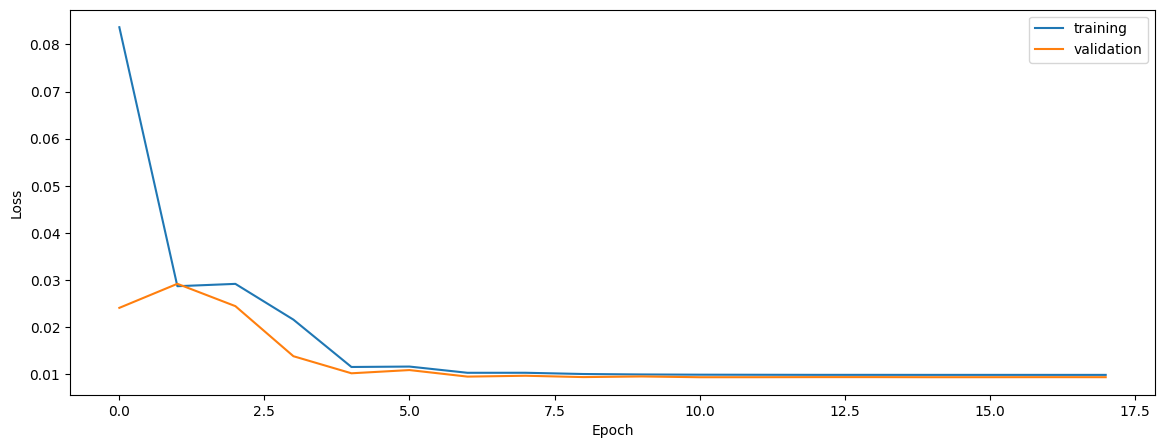

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.1252060776801633
0.16871014004434975
0.08615730443624747


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.1252060776801633
0.16871014004434975
0.08615730443624747


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.1198242150989701
0.158891553535201
0.09372838920719939


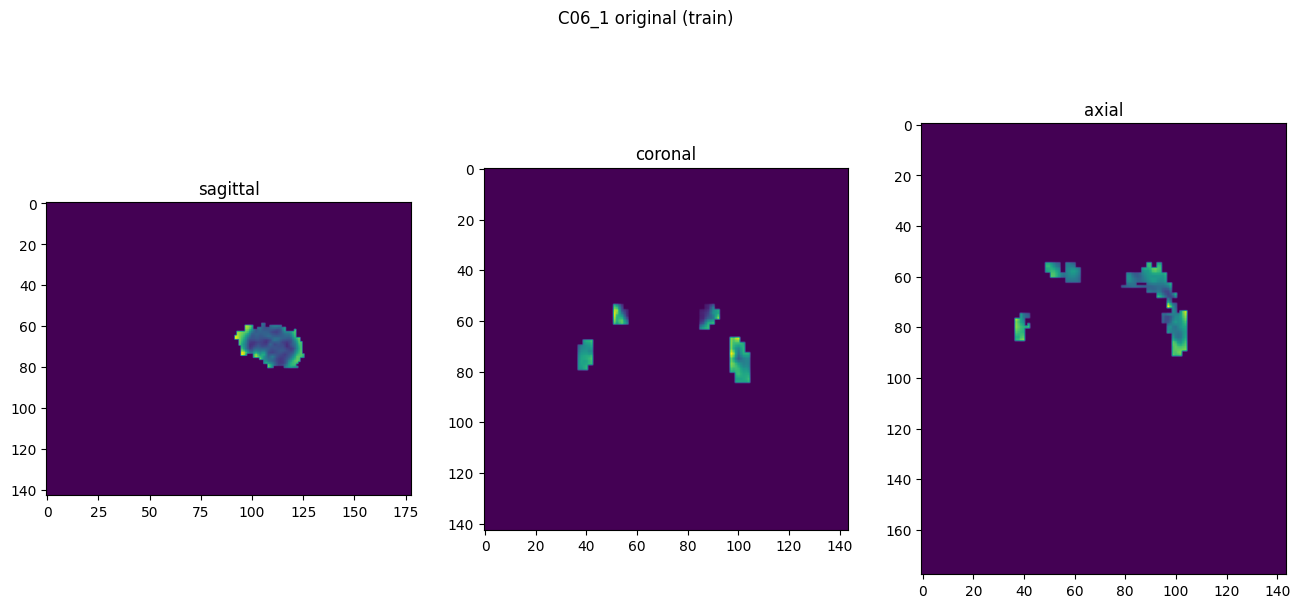

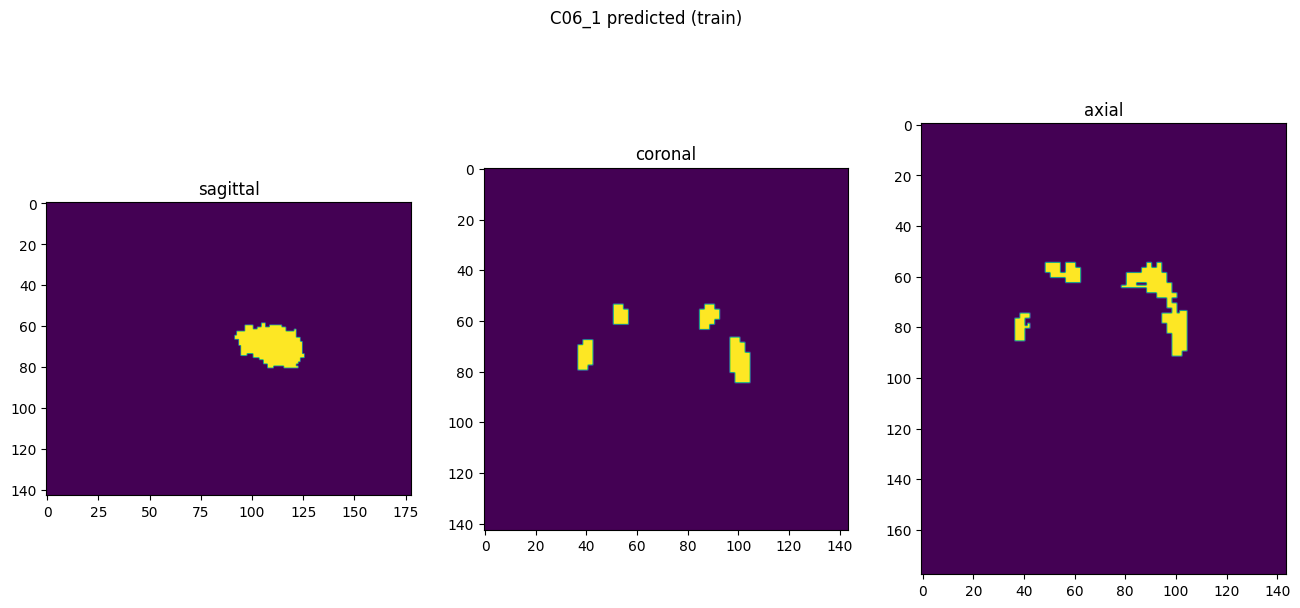

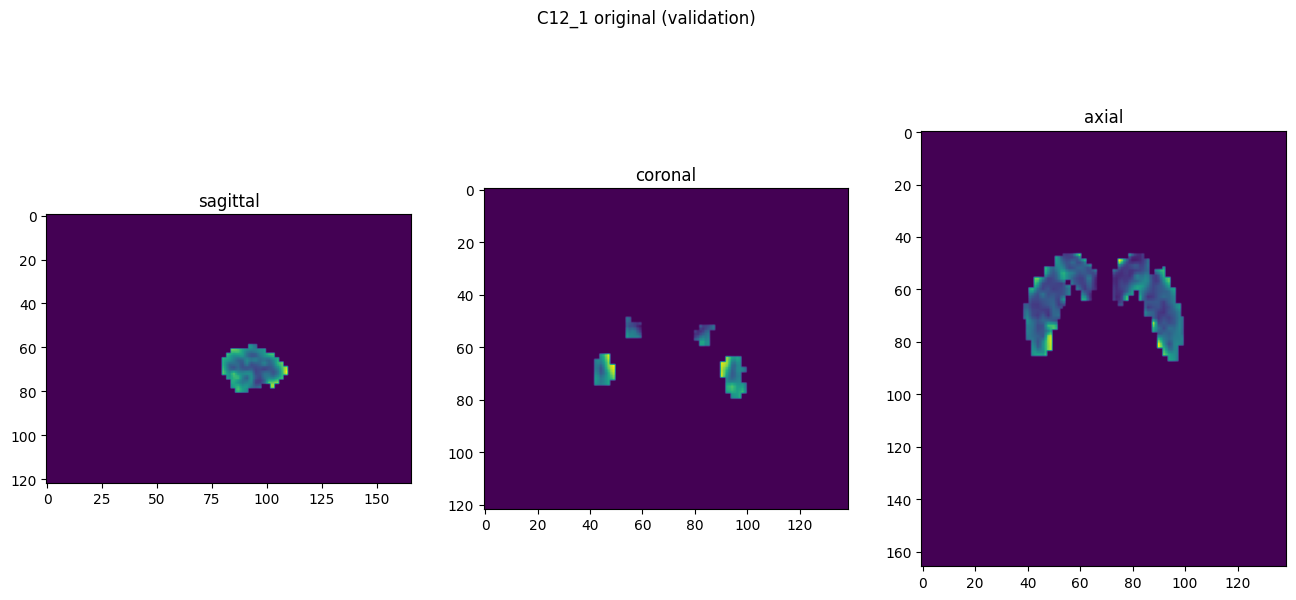

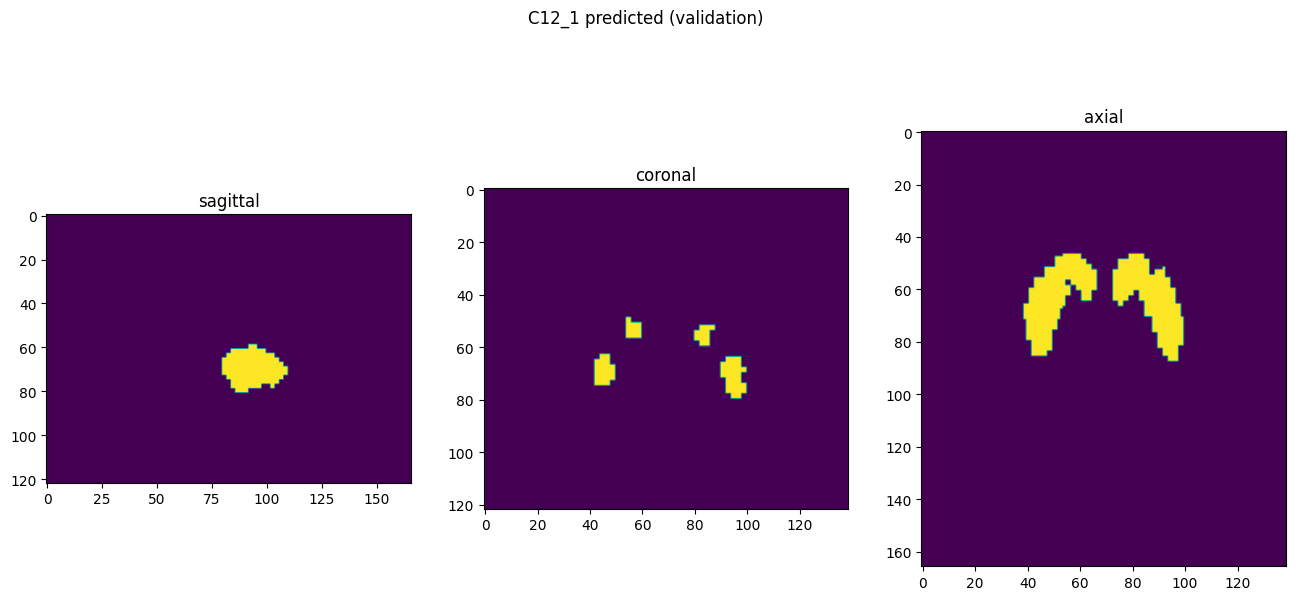

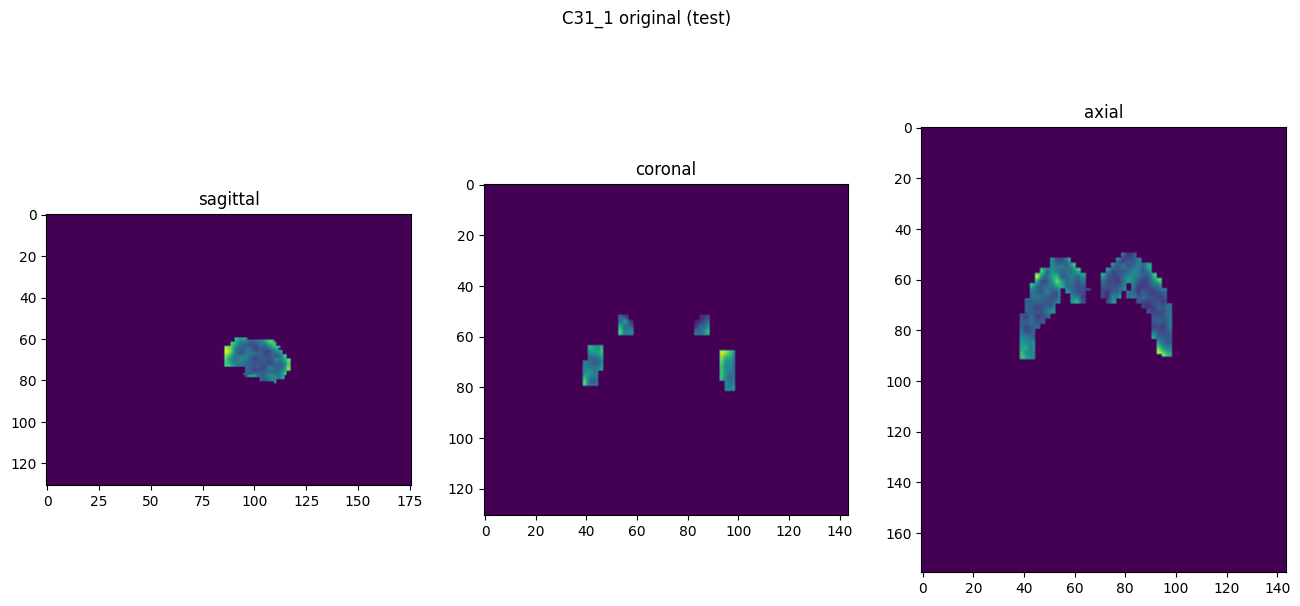

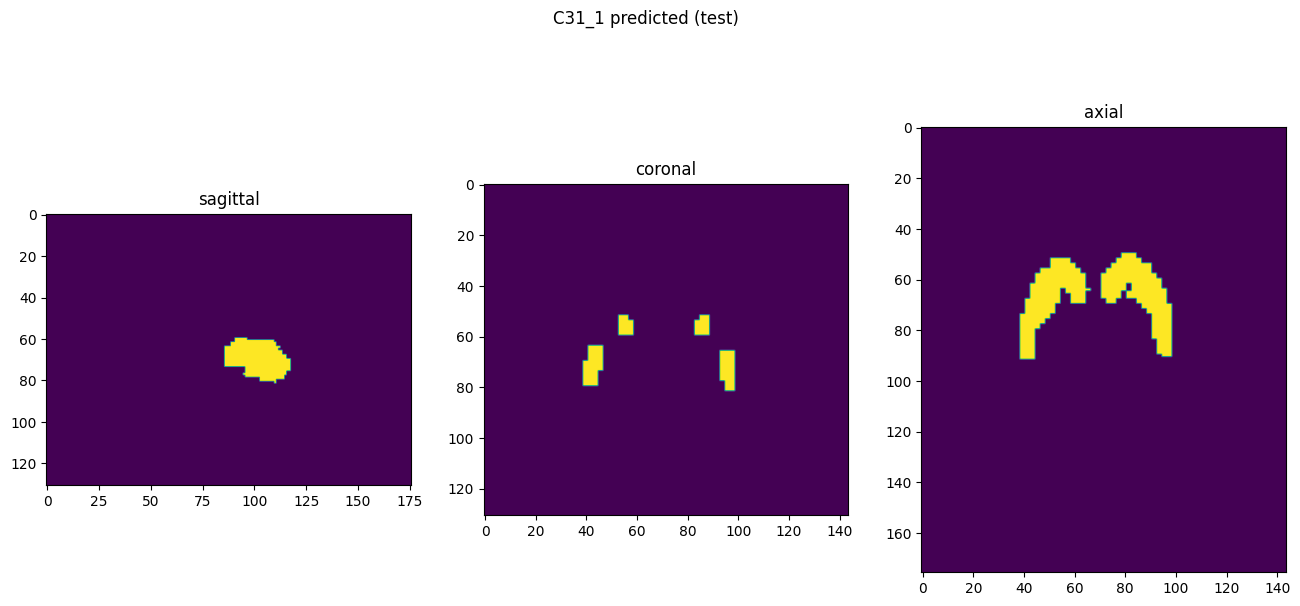

In [10]:
showResults(model, gen, threshold=None, background=False)